# Questions:

1. does more shares relate to more social visits?
2. do orgs with more shares or social visits get more donations?
3. do orgs with more shares or social visits have higher or lower average donation sizes?
4. do orgs with more shares or social visits have higher or lower conversion?
5. how many visits does each share get?

In [176]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '../../../scripts/')
from s3_support import *
%matplotlib inline

In [87]:
# collect social data
fb = get_dataframe_from_file("qgiv-stats-data", "social.facebook.csv")
tw = get_dataframe_from_file("qgiv-stats-data", "social.twitter.csv")
q = '''select 
            org,
            form,
            count(id) as count,
            sum(amount) as volume
        from transactions
        where status='A' and date>='2020-11-01' and date<='2020-12-03'
        group by org, form'''
trans = redshift_query_read(q, schema="public")
q = "select * from googleanalytics_referrer"
ga_referrers = redshift_query_read(q, schema="public")

In [55]:
tw['date_created'].min(), tw['date_created'].max()

('2020-11-23 15:18:56', '2020-12-03 16:09:05')

# 1. does more shares relate to more social visits?

In [89]:
ga_referrers['date'].min(), ga_referrers['date'].max()

(Timestamp('2019-12-29 00:00:00'), Timestamp('2020-11-07 00:00:00'))

In [97]:
form_social_views = ga_referrers[ga_referrers['facebook']|ga_referrers['twitter']].groupby(['org', 'form', 'facebook', 'twitter'])['views'].sum().reset_index()
form_social_views = form_social_views[form_social_views['org']!=0]
form_social_views.head(3)

,org,form,facebook,twitter,views
2,6,1,True,False,48
3,6,953404,True,False,2
4,9,159827,True,False,30


In [126]:
social_views_data = []
for form in form_social_views['form'].unique():
    _df = form_social_views[form_social_views['form']==form]
    
    social_views_data.append({
        'org': _df['org'].iloc[0],
        'form': form,
        'twitter_views': _df[_df['twitter']]['views'].sum(),
        'facebook_views': _df[_df['facebook']]['views'].sum()
    })
social_views_df = pd.DataFrame(social_views_data)

In [127]:
# adding twitter shares
form_twitter_counts = tw.groupby('form')['tweet_id'].count().reset_index()
social_views_df = social_views_df.merge(form_twitter_counts, on='form')
# adding facebook shares
form_facebook_counts = fb.groupby('form')['share_count'].sum().reset_index()
social_views_df = social_views_df.merge(form_facebook_counts, on='form')
# cleaning up columns
social_views_df = social_views_df[['org', 'form', 'facebook_views', 'twitter_views', 'tweet_id', 'share_count']]
social_views_df.columns = ['org', 'form', 'facebook_views', 'twitter_views', 'twitter_shares', 'facebook_shares']

In [128]:
social_views_df.head(3)

,org,form,facebook_views,twitter_views,twitter_shares,facebook_shares
0,682,654,10,0,3,2
1,781,96354,4,0,3,235
2,874,863,0,4,2,1


In [182]:
social_views_df.groupby('facebook_shares')['facebook_views'].mean().reset_index().corr()

,facebook_shares,facebook_views
facebook_shares,1.000000,0.158142
facebook_views,0.158142,1.000000


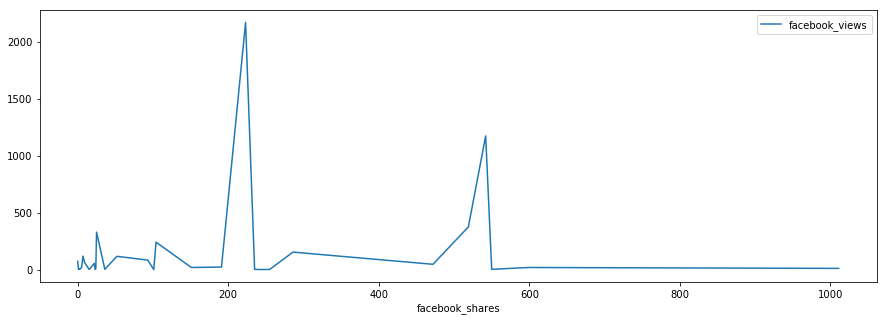

In [129]:
social_views_df.groupby('facebook_shares')['facebook_views'].mean().reset_index().plot(x='facebook_shares', figsize=(15,5))

In [183]:
social_views_df.groupby('twitter_shares')['twitter_views'].mean().reset_index().corr()

,twitter_shares,twitter_views
twitter_shares,1.000000,-0.201147
twitter_views,-0.201147,1.000000


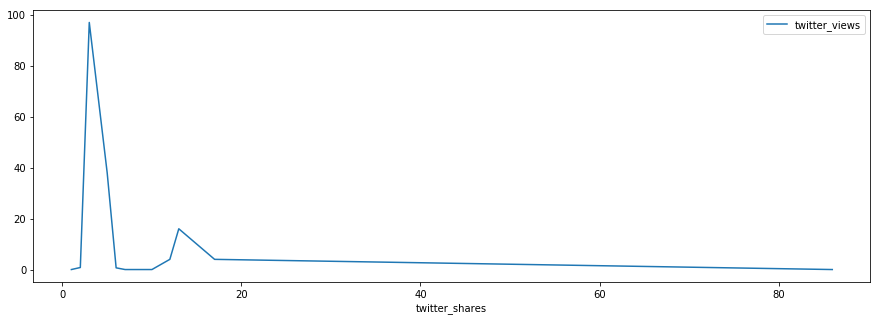

In [130]:
social_views_df.groupby('twitter_shares')['twitter_views'].mean().reset_index().plot(x='twitter_shares', figsize=(15,5))

# 2. do orgs with more shares or social visits get more donations?

### Twitter

In [63]:
tw_grpd = tw.groupby(['form']).agg({'tweet_id': 'count', 'like_count': 'sum', 'retweet_count': 'sum'}).reset_index()
tw_grpd.columns = ['form', 'tweets', 'likes', 'retweets']
tw_grpd = tw_grpd.merge(trans, on=['form'])
tw_grpd = tw_grpd[['org', 'form', 'tweets', 'likes', 'retweets', 'count', 'volume']]
tw_grpd.columns = ['org', 'form', 'tweets', 'likes', 'retweets', 'trans_count', 'trans_volume']

In [65]:
tw_grpd.head(3)

,org,form,tweets,likes,retweets,trans_count,trans_volume
0,682,654,3,3,2,26,2264.92
1,829,818,1,0,0,21,5430.00
2,859,848,1,0,0,9,1785.00


In [187]:
tw_grpd.groupby('tweets')[['trans_count', 'trans_volume']].mean().reset_index().corr()

,tweets,trans_count,trans_volume
tweets,1.000000,-0.058975,0.015035
trans_count,-0.058975,1.000000,0.685177
trans_volume,0.015035,0.685177,1.000000


In [186]:
tw_grpd.groupby('retweets')[['trans_count', 'trans_volume']].mean().reset_index().corr()

,retweets,trans_count,trans_volume
retweets,1.000000,-0.069793,-0.023850
trans_count,-0.069793,1.000000,0.865209
trans_volume,-0.023850,0.865209,1.000000


Tweet count


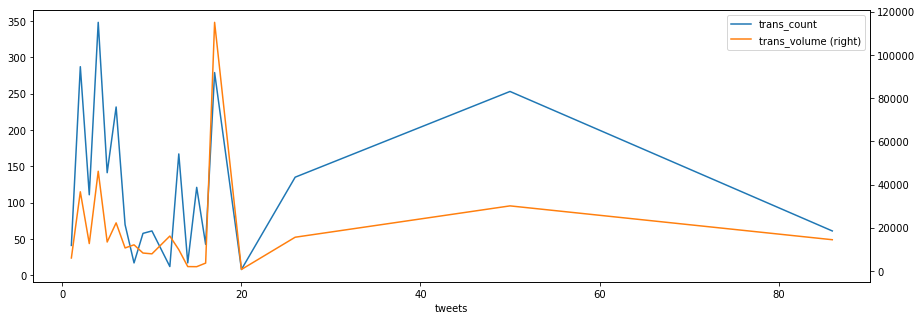

In [76]:
print("Tweet count")
tw_grpd.groupby('tweets')[['trans_count', 'trans_volume']].mean().reset_index().plot(x='tweets', y=['trans_count', 'trans_volume'], secondary_y='trans_volume', figsize=(15,5))

Retweet count


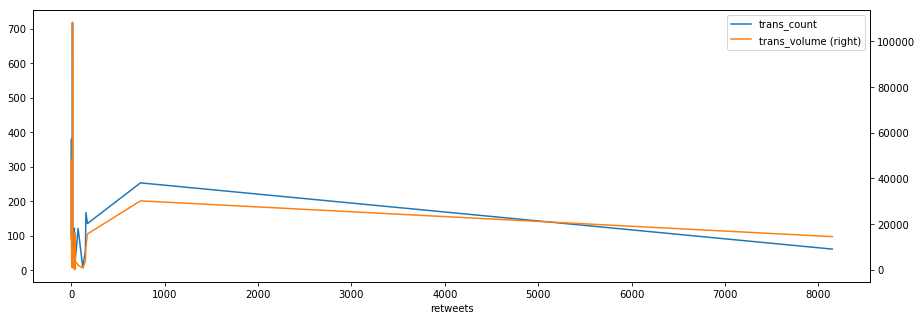

In [77]:
print("Retweet count")
tw_grpd.groupby('retweets')[['trans_count', 'trans_volume']].mean().reset_index().plot(x='retweets', y=['trans_count', 'trans_volume'], secondary_y='trans_volume', figsize=(15,5))

In [185]:
tw_grpd.groupby('likes')[['trans_count', 'trans_volume']].mean().reset_index().corr()

,likes,trans_count,trans_volume
likes,1.000000,-0.056547,-0.058112
trans_count,-0.056547,1.000000,0.787852
trans_volume,-0.058112,0.787852,1.000000


Likes count


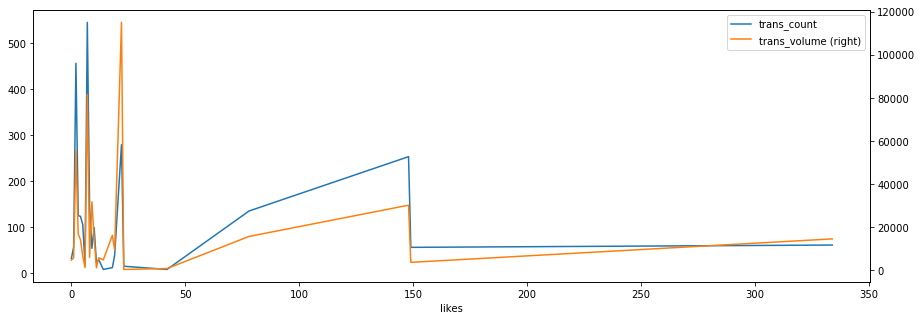

In [78]:
print("Likes count")
tw_grpd.groupby('likes')[['trans_count', 'trans_volume']].mean().reset_index().plot(x='likes', y=['trans_count', 'trans_volume'], secondary_y='trans_volume', figsize=(15,5))

### Facebook

In [75]:
fb_grpd = fb[['org', 'form', 'reaction_count', 'comment_count', 'share_count']].merge(trans, on=['form', 'org'])
fb_grpd.columns = ['org', 'form', 'reaction_count', 'comment_count', 'share_count', 'trans_count', 'trans_volume']
fb_grpd.head()

,org,form,reaction_count,comment_count,share_count,trans_count,trans_volume
0,66.0,40,0,0,0,1,20.00
1,98.0,72,94,12,15,10,5920.00
2,243.0,216,0,0,0,208,23414.25
3,340.0,312,0,0,0,1,170.00
4,468.0,440,13,1,8,33,8212.52


In [189]:
fb_grpd.groupby('reaction_count')[['trans_count', 'trans_volume']].mean().reset_index().corr()

,reaction_count,trans_count,trans_volume
reaction_count,1.000000,0.002427,-0.007129
trans_count,0.002427,1.000000,0.977563
trans_volume,-0.007129,0.977563,1.000000


Reaction count


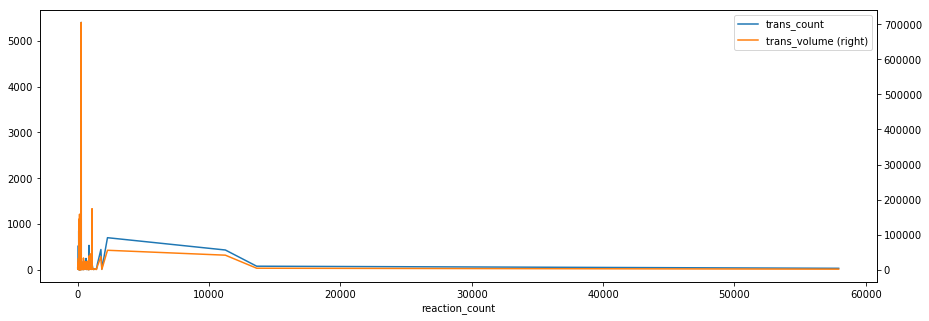

In [84]:
print("Reaction count")
fb_grpd.groupby('reaction_count')[['trans_count', 'trans_volume']].mean().reset_index().plot(x='reaction_count', y=['trans_count', 'trans_volume'], secondary_y='trans_volume', figsize=(15,5))

In [190]:
fb_grpd.groupby('share_count')[['trans_count', 'trans_volume']].mean().reset_index().corr()

,share_count,trans_count,trans_volume
share_count,1.000000,-0.011734,-0.021911
trans_count,-0.011734,1.000000,0.945822
trans_volume,-0.021911,0.945822,1.000000


Share count


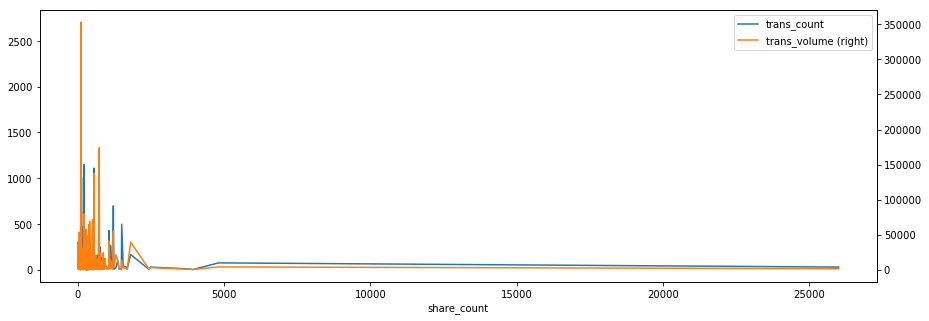

In [86]:
print("Comment count")
fb_grpd.groupby('share_count')[['trans_count', 'trans_volume']].mean().reset_index().plot(x='share_count', y=['trans_count', 'trans_volume'], secondary_y='trans_volume', figsize=(15,5))

## avergaes for socially engaged

In [243]:
tw_forms = trans[trans['form'].isin(tw_grpd['form'].unique())]
fb_forms = trans[trans['form'].isin(fb_grpd['form'].unique())]
nse_forms = trans[~trans['form'].isin(tw_grpd['form'].unique())&~trans['form'].isin(fb_grpd['form'].unique())]

print("Transaction Counts:")
print("All ({}): mean {:.2f}, median {:.2f}".format(len(trans['form'].unique()), trans['count'].mean(), trans['count'].median()))
print("FB ({}): mean {:.2f}, median {:.2f}".format(len(fb_forms['form'].unique()), fb_forms['count'].mean(), fb_forms['count'].median()))
print("TW ({}): mean {:.2f}, median {:.2f}".format(len(tw_forms['form'].unique()), tw_forms['count'].mean(), tw_forms['count'].median()))
print("Not socially engaged ({}): mean {:.2f}, median {:.2f}".format(len(nse_forms['form'].unique()), nse_forms['count'].mean(), nse_forms['count'].median()))

print()
print("Transaction Volume:")
print("All ({}): mean ${:,.2f}, median ${:,.2f}".format(len(trans['form'].unique()), trans['volume'].mean(), trans['volume'].median()))
print("FB ({}): mean ${:,.2f}, median ${:,.2f}".format(len(fb_forms['form'].unique()), fb_forms['volume'].mean(), fb_forms['volume'].median()))
print("TW ({}): mean ${:,.2f}, median ${:,.2f}".format(len(tw_forms['form'].unique()), tw_forms['volume'].mean(), tw_forms['volume'].median()))
print("Not socially engaged ({}): mean ${:,.2f}, median ${:,.2f}".format(len(nse_forms['form'].unique()), nse_forms['volume'].mean(), nse_forms['volume'].median()))

Transaction Counts:
All (6783): mean 39.89, median 6.00
FB (6386): mean 41.30, median 7.00
TW (148): mean 121.59, median 23.00
Not socially engaged (397): mean 17.18, median 2.00

Transaction Volume:
All (6783): mean $4,816.71, median $519.75
FB (6386): mean $5,010.83, median $589.00
TW (148): mean $15,972.23, median $3,560.60
Not socially engaged (397): mean $1,694.27, median $106.00


# 3. do orgs with more shares or social visits have higher or lower average donation sizes?

In [233]:
trans['avg_amount'] = trans['volume'] / trans['count']

len(trans), trans['avg_amount'].mean(), trans['avg_amount'].median()

(6783, 162.83417457591864, 71.34181818181818)

In [232]:
nse = trans[~trans['form'].isin(fb_grpd['form'].tolist())].copy()
nse = nse[~nse['form'].isin(tw_grpd['form'].tolist())]
len(nse), nse['avg_amount'].mean(), nse['avg_amount'].median()

(397, 126.27512173016943, 49.07260115606936)

In [230]:
nse.tail()

,org,form,count,volume
6725,438481,932173,1,15.0
6731,445546,966401,1,500.0
6766,445556,957765,1,1.0
6767,31794,940052,1,10.3
6778,445262,957508,1,250.0


### Twitter

In [226]:
tw_grpd['avg_trans'] = tw_grpd['trans_volume'] / tw_grpd['trans_count']

"{:,.2f}".format(tw_grpd['avg_trans'].mean()), "{:,.2f}".format(tw_grpd['avg_trans'].median())

('178.57', '112.87')

In [195]:
tw_grpd.groupby('tweets')['avg_trans'].mean().reset_index().corr()

,tweets,avg_trans
tweets,1.000000,-0.050647
avg_trans,-0.050647,1.000000


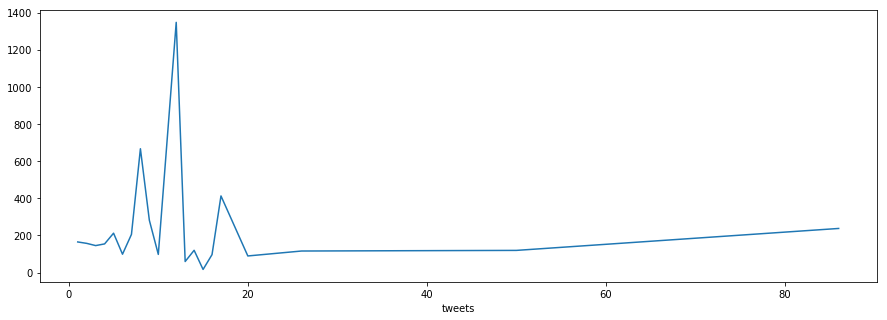

In [134]:
tw_grpd.groupby('tweets')['avg_trans'].mean().plot(x='tweets', figsize=(15,5))

In [205]:
tw_grpd.groupby('tweets')['avg_trans'].agg({'count', 'mean'}).reset_index().head(10)

,tweets,count,mean
0,1,64,164.540417
1,2,22,156.957167
2,3,15,144.959056
3,4,8,154.030853
4,5,6,211.805543
5,6,8,98.534326
6,7,6,205.312931
7,8,3,666.641124
8,9,3,281.109117
9,10,2,97.527657


### Facebook

In [227]:
fb_grpd['avg_trans'] = fb_grpd['trans_volume'] / fb_grpd['trans_count']

"{:,.2f}".format(fb_grpd['avg_trans'].mean()), "{:,.2f}".format(fb_grpd['avg_trans'].median())

('165.11', '74.90')

In [203]:
fb_grpd.groupby('share_count')['avg_trans'].agg({'count', 'mean'}).reset_index().head(15)

,share_count,count,mean
0,0,4853,171.441086
1,1,269,125.085713
2,2,135,143.134567
3,3,118,145.940254
4,4,71,164.728603
5,5,60,110.496807
6,6,43,116.375871
7,7,31,164.650876
8,8,32,196.255398
9,9,23,98.054155


In [196]:
fb_grpd.groupby('share_count')['avg_trans'].mean().reset_index().corr()

,share_count,avg_trans
share_count,1.000000,-0.053151
avg_trans,-0.053151,1.000000


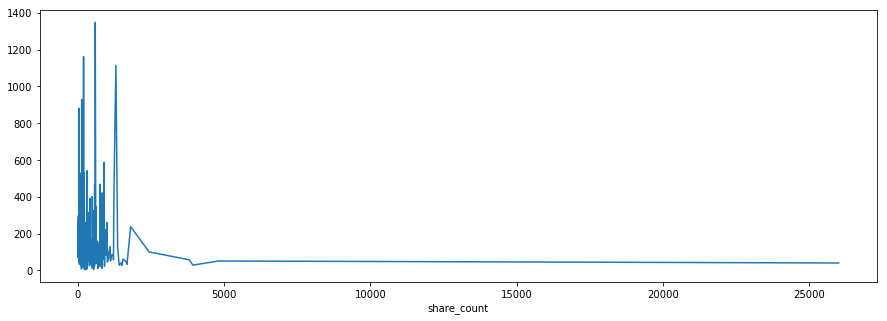

In [137]:
fb_grpd.groupby('share_count')['avg_trans'].mean().plot(x='tweets', figsize=(15,5))

# 4. do orgs with more shares or social visits have higher or lower conversion?

In [157]:
# get conversion
q = '''select 
            date_trunc('month', date) as month, 
            form, 
            sum(views) as views 
        from googleanalytics_traffic 
        where date>='2020-01-01'
        group by form, date_trunc('month', date)'''
ga = redshift_query_read(q, schema="public")
q = '''select
            date_trunc('month', date) as month,
            form,
            count(id) as count,
            sum(amount) as vol
        from transactions
        where status='A' and recurring=0
        group by form, date_trunc('month', date)'''
trans_month = redshift_query_read(q, schema="public")
conv = ga.merge(trans_month, on=['form', 'month'])
conv['conversion'] = conv['count'] / conv['views']

In [158]:
def get_fb_active(form):
    fb_cols = ['reaction_count', 'comment_count', 'share_count']
    if len(fb_grpd[fb_grpd['form']==form]) > 0:
        return fb_grpd[fb_grpd['form']==form][fb_cols].sum().iloc[0]
    else:
        return 0
    
def get_tw_active(form):
    tw_cols = ['tweets', 'likes', 'retweets']
    if len(tw_grpd[tw_grpd['form']==form]) > 0:
        return tw_grpd[tw_grpd['form']==form][tw_cols].sum().iloc[0]
    else:
        return 0
    
conv['fb_engagement'] = conv['form'].apply(get_fb_active)
conv['tw_engagement'] = conv['form'].apply(get_tw_active)

In [159]:
conv[['conversion', 'fb_engagement', 'tw_engagement']].corr()

,conversion,fb_engagement,tw_engagement
conversion,1.000000,-0.003162,-0.008462
fb_engagement,-0.003162,1.000000,0.013047
tw_engagement,-0.008462,0.013047,1.000000


In [223]:
# aggregate by orgs w/ social visits and w/out
print("All: {:.2f}% mean, {:.2f}% median".format(conv['conversion'].mean() * 100., conv['conversion'].median() * 100.))
print("FB active: {:.2f}% mean, {:.2f}% median".format(conv[conv['fb_engagement']>0]['conversion'].mean() * 100., conv[conv['fb_engagement']>0]['conversion'].median() * 100.))
print("TW active: {:.2f}% mean, {:.2f}% median".format(conv[conv['tw_engagement']>0]['conversion'].mean() * 100., conv[conv['tw_engagement']>0]['conversion'].median() * 100.))
print("Social inactive: {:.2f}% mean, {:.2f}% median".format(conv[(conv['tw_engagement']==0)&(conv['fb_engagement']==0)]['conversion'].mean() * 100., conv[(conv['tw_engagement']==0)&(conv['fb_engagement']==0)]['conversion'].median() * 100.))

All: 25.85% mean, 7.50% median
FB active: 15.48% mean, 7.14% median
TW active: 7.14% mean, 5.20% median
Social inactive: 30.10% mean, 7.69% median


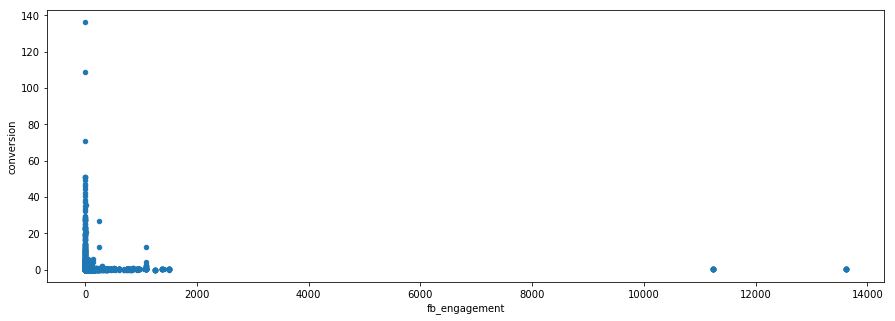

In [164]:
conv[['fb_engagement', 'conversion']].plot(kind="scatter", x='fb_engagement', y='conversion', figsize=(15,5))

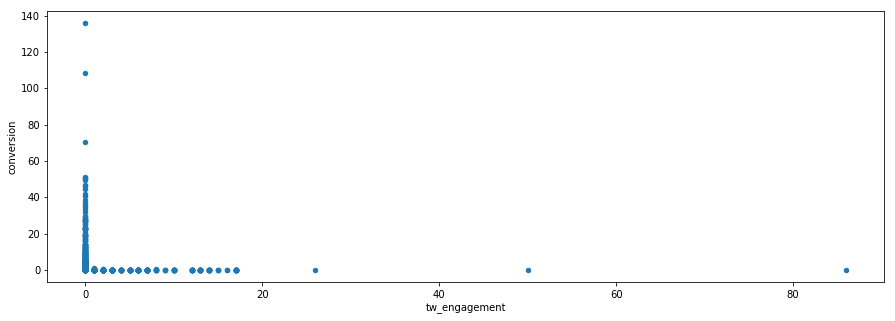

In [165]:
conv[['tw_engagement', 'conversion']].plot(kind="scatter", x='tw_engagement', y='conversion', figsize=(15,5))

# 5. how many visits does each share get?

In [181]:
social_views_df['facebook_ratio'] = social_views_df['facebook_views'] / social_views_df['facebook_shares']
social_views_df['twitter_ratio'] = social_views_df['twitter_views'] / social_views_df['twitter_shares']

print("FB: mean {:.2f}, median {:.2f} views per share".format(social_views_df['facebook_ratio'].replace(np.inf, np.nan).dropna().mean(), social_views_df['facebook_ratio'].replace(np.inf, np.nan).dropna().median()))
print("TW: mean {:.2f}, median {:.2f} views per share".format(social_views_df['twitter_ratio'].replace(np.inf, np.nan).dropna().mean(), social_views_df['twitter_ratio'].replace(np.inf, np.nan).dropna().median()))

FB: mean 2.47, median 0.54 views per share
TW: mean 3.53, median 0.00 views per share


In [167]:
social_views_df[['facebook_views', 'facebook_shares']].corr()

,facebook_views,facebook_shares
facebook_views,1.000000,0.192228
facebook_shares,0.192228,1.000000


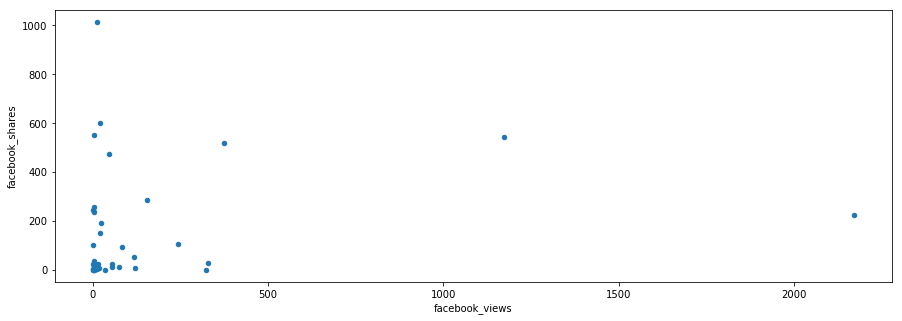

In [169]:
social_views_df[['facebook_views', 'facebook_shares']].plot(kind='scatter', x='facebook_views', y='facebook_shares', figsize=(15,5))

In [168]:
social_views_df[['twitter_views', 'twitter_shares']].corr()

,twitter_views,twitter_shares
twitter_views,1.000000,-0.028405
twitter_shares,-0.028405,1.000000


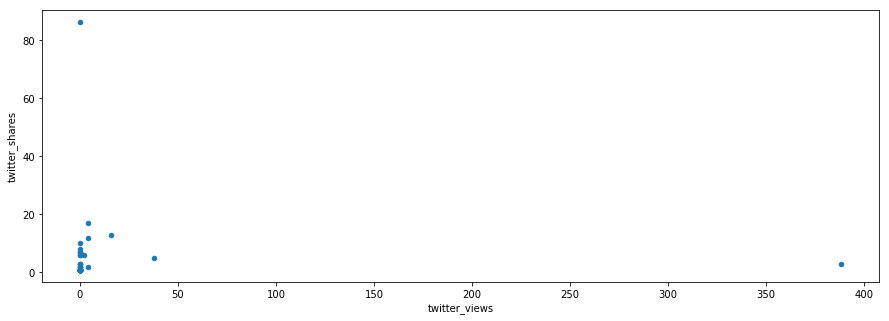

In [170]:
social_views_df[['twitter_views', 'twitter_shares']].plot(kind='scatter', x='twitter_views', y='twitter_shares', figsize=(15,5))